# Повышение качества изображений на основе ESPCN с использованием датасета the-car-connection

https://medium.datadriveninvestor.com/review-espcn-real-time-sr-super-resolution-8dceca249350

In [1]:
# Импорт необходимых библиотек
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import kagglehub

# car_connection_path = kagglehub.dataset_download("prondeau/the-car-connection-picture-dataset")

## Загрузка и Предобработка Данных

Реализуем модель повышения разрешения изображений автомобилей на основе архитектуры ESPCN (Efficient Sub-Pixel Convolutional Neural Network). Датасет состоит из 60,000+ изображений автомобилей.


Загрузим изображения, создадим низкоразрешенные версии изображений и подготовим пары для обучения.

In [2]:
# Путь к датасету
DATA_DIR = '/kaggle/input/the-car-connection-picture-dataset/' 

# Параметры
IMAGE_SIZE = 128  # Размер высокоразрешенных изображений
SCALE = 2         # Коэффициент масштабирования
LOW_RES_SIZE = IMAGE_SIZE // SCALE  # Размер низкоразрешенных изображений

def create_low_res_image(high_res_image, scale):
    high_res_image = (high_res_image + 1.0) * 127.5
    high_res_image = tf.cast(high_res_image, tf.uint8)
    
    low_res_image = tf.image.resize(high_res_image, [LOW_RES_SIZE, LOW_RES_SIZE], method='bicubic')
    low_res_image = tf.cast(low_res_image, tf.float32) / 127.5 - 1.0
    
    return low_res_image

all_image_files = [os.path.join(DATA_DIR, fname) for fname in os.listdir(DATA_DIR) if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

train_files, test_files = train_test_split(all_image_files, test_size=0.1, random_state=42)

In [3]:
# Параметры для потоковой загрузки
BATCH_SIZE = 16
AUTOTUNE = tf.data.experimental.AUTOTUNE

def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Изменение размера (высокое разрешение)
    high_res = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    high_res = high_res / 127.5 - 1.0  # Нормализация до [-1, 1]
    
    # Изменение размера (низкое разрешение)
    low_res = tf.image.resize(image, [LOW_RES_SIZE, LOW_RES_SIZE], method='bicubic')
    low_res = low_res / 127.5 - 1.0  # Нормализация до [-1, 1]
    
    return low_res, high_res

# Обертка для использования tf.py_function
def tf_load_and_preprocess_image(file_path):
    return tf.py_function(
        func=load_and_preprocess_image,
        inp=[file_path],
        Tout=(tf.float32, tf.float32)
    )

# Создание TensorFlow датасета для тренировки
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Создание TensorFlow датасета для валидации
validation_dataset = tf.data.Dataset.from_tensor_slices(test_files)
validation_dataset = validation_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

Реализуем модель ESPCN, которая использует суб-пиксельную свертку для повышения разрешения изображений.

Используем `ModelCheckpoint` для сохранения лучших моделей и `EarlyStopping` для предотвращения переобучения.

In [4]:
# Создание модели ESPCN
def build_espcn(scale, channels=3):
    input_img = layers.Input(shape=(None, None, channels), name='low_res_input')
    x = layers.Conv2D(64, kernel_size=5, padding='same', activation='relu')(input_img)
    x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D((scale ** 2) * channels, kernel_size=3, padding='same')(x)
    output_img = layers.Lambda(lambda x: tf.nn.depth_to_space(x, scale))(x)
    model = models.Model(inputs=input_img, outputs=output_img, name='ESPCN')
    return model

model = build_espcn(scale=SCALE, channels=3)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')

checkpoint = ModelCheckpoint(filepath='espcn_epoch_{epoch:02d}.weights.h5', save_freq='epoch', save_weights_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

Model: "ESPCN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ low_res_input (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, None, None, 64)      │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, None, None, 32)      │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, None, None, 12)      │           3,468 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, None, None, 3)       │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,796 (104.67 KB)

 Trainable params: 26,796 (104.67 KB)

 Non-trainable params: 0 (0.00 B)

Запускаем процесс обучения модели с использованием подготовленных датасетов и коллбеков. Отображаем графики потерь генератора на тренировочном и валидационном наборах.

In [23]:
EPOCHS = 30

# Обучение модели
# history = model.fit(
#     train_dataset,
#     epochs=EPOCHS,
#     validation_data=validation_dataset,
#     callbacks=[checkpoint, early_stop]
# )

# plt.figure(figsize=(10, 5))
# plt.plot(history.history['loss'], label='Тренировочная потеря')
# plt.plot(history.history['val_loss'], label='Валидационная потеря')
# plt.title('Потери во время обучения')
# plt.xlabel('Эпоха')
# plt.ylabel('MSE Потеря')
# plt.legend()
# plt.show()

# model.save('espcn_final.h5')

In [21]:
# Восстановление архитектуры модели
def build_espcn(scale, channels=3):
    input_img = layers.Input(shape=(None, None, channels), name='low_res_input')
    
    x = layers.Conv2D(64, kernel_size=5, padding='same', activation='relu')(input_img)
    x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D((scale**2) * channels, kernel_size=3, padding='same')(x)
    
    def depth_to_space(x):
        return tf.nn.depth_to_space(x, scale)
    
    output_img = layers.Lambda(depth_to_space, output_shape=(None, None, 3))(x)
    
    model = models.Model(inputs=input_img, outputs=output_img, name='ESPCN')
    return model

model = build_espcn(SCALE)
model.load_weights('/kaggle/input/espcn_cars/keras/3/1/espcn_fixed_model.h5')
model.summary()

Model: "ESPCN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ low_res_input (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, None, None, 64)      │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, None, None, 32)      │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, None, None, 12)      │           3,468 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, None, None, 3)       │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,796 (104.67 KB)

 Trainable params: 26,796 (104.67 KB)

 Non-trainable params: 0 (0.00 B)

Функция для повышения разрешения и отображения результатов.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


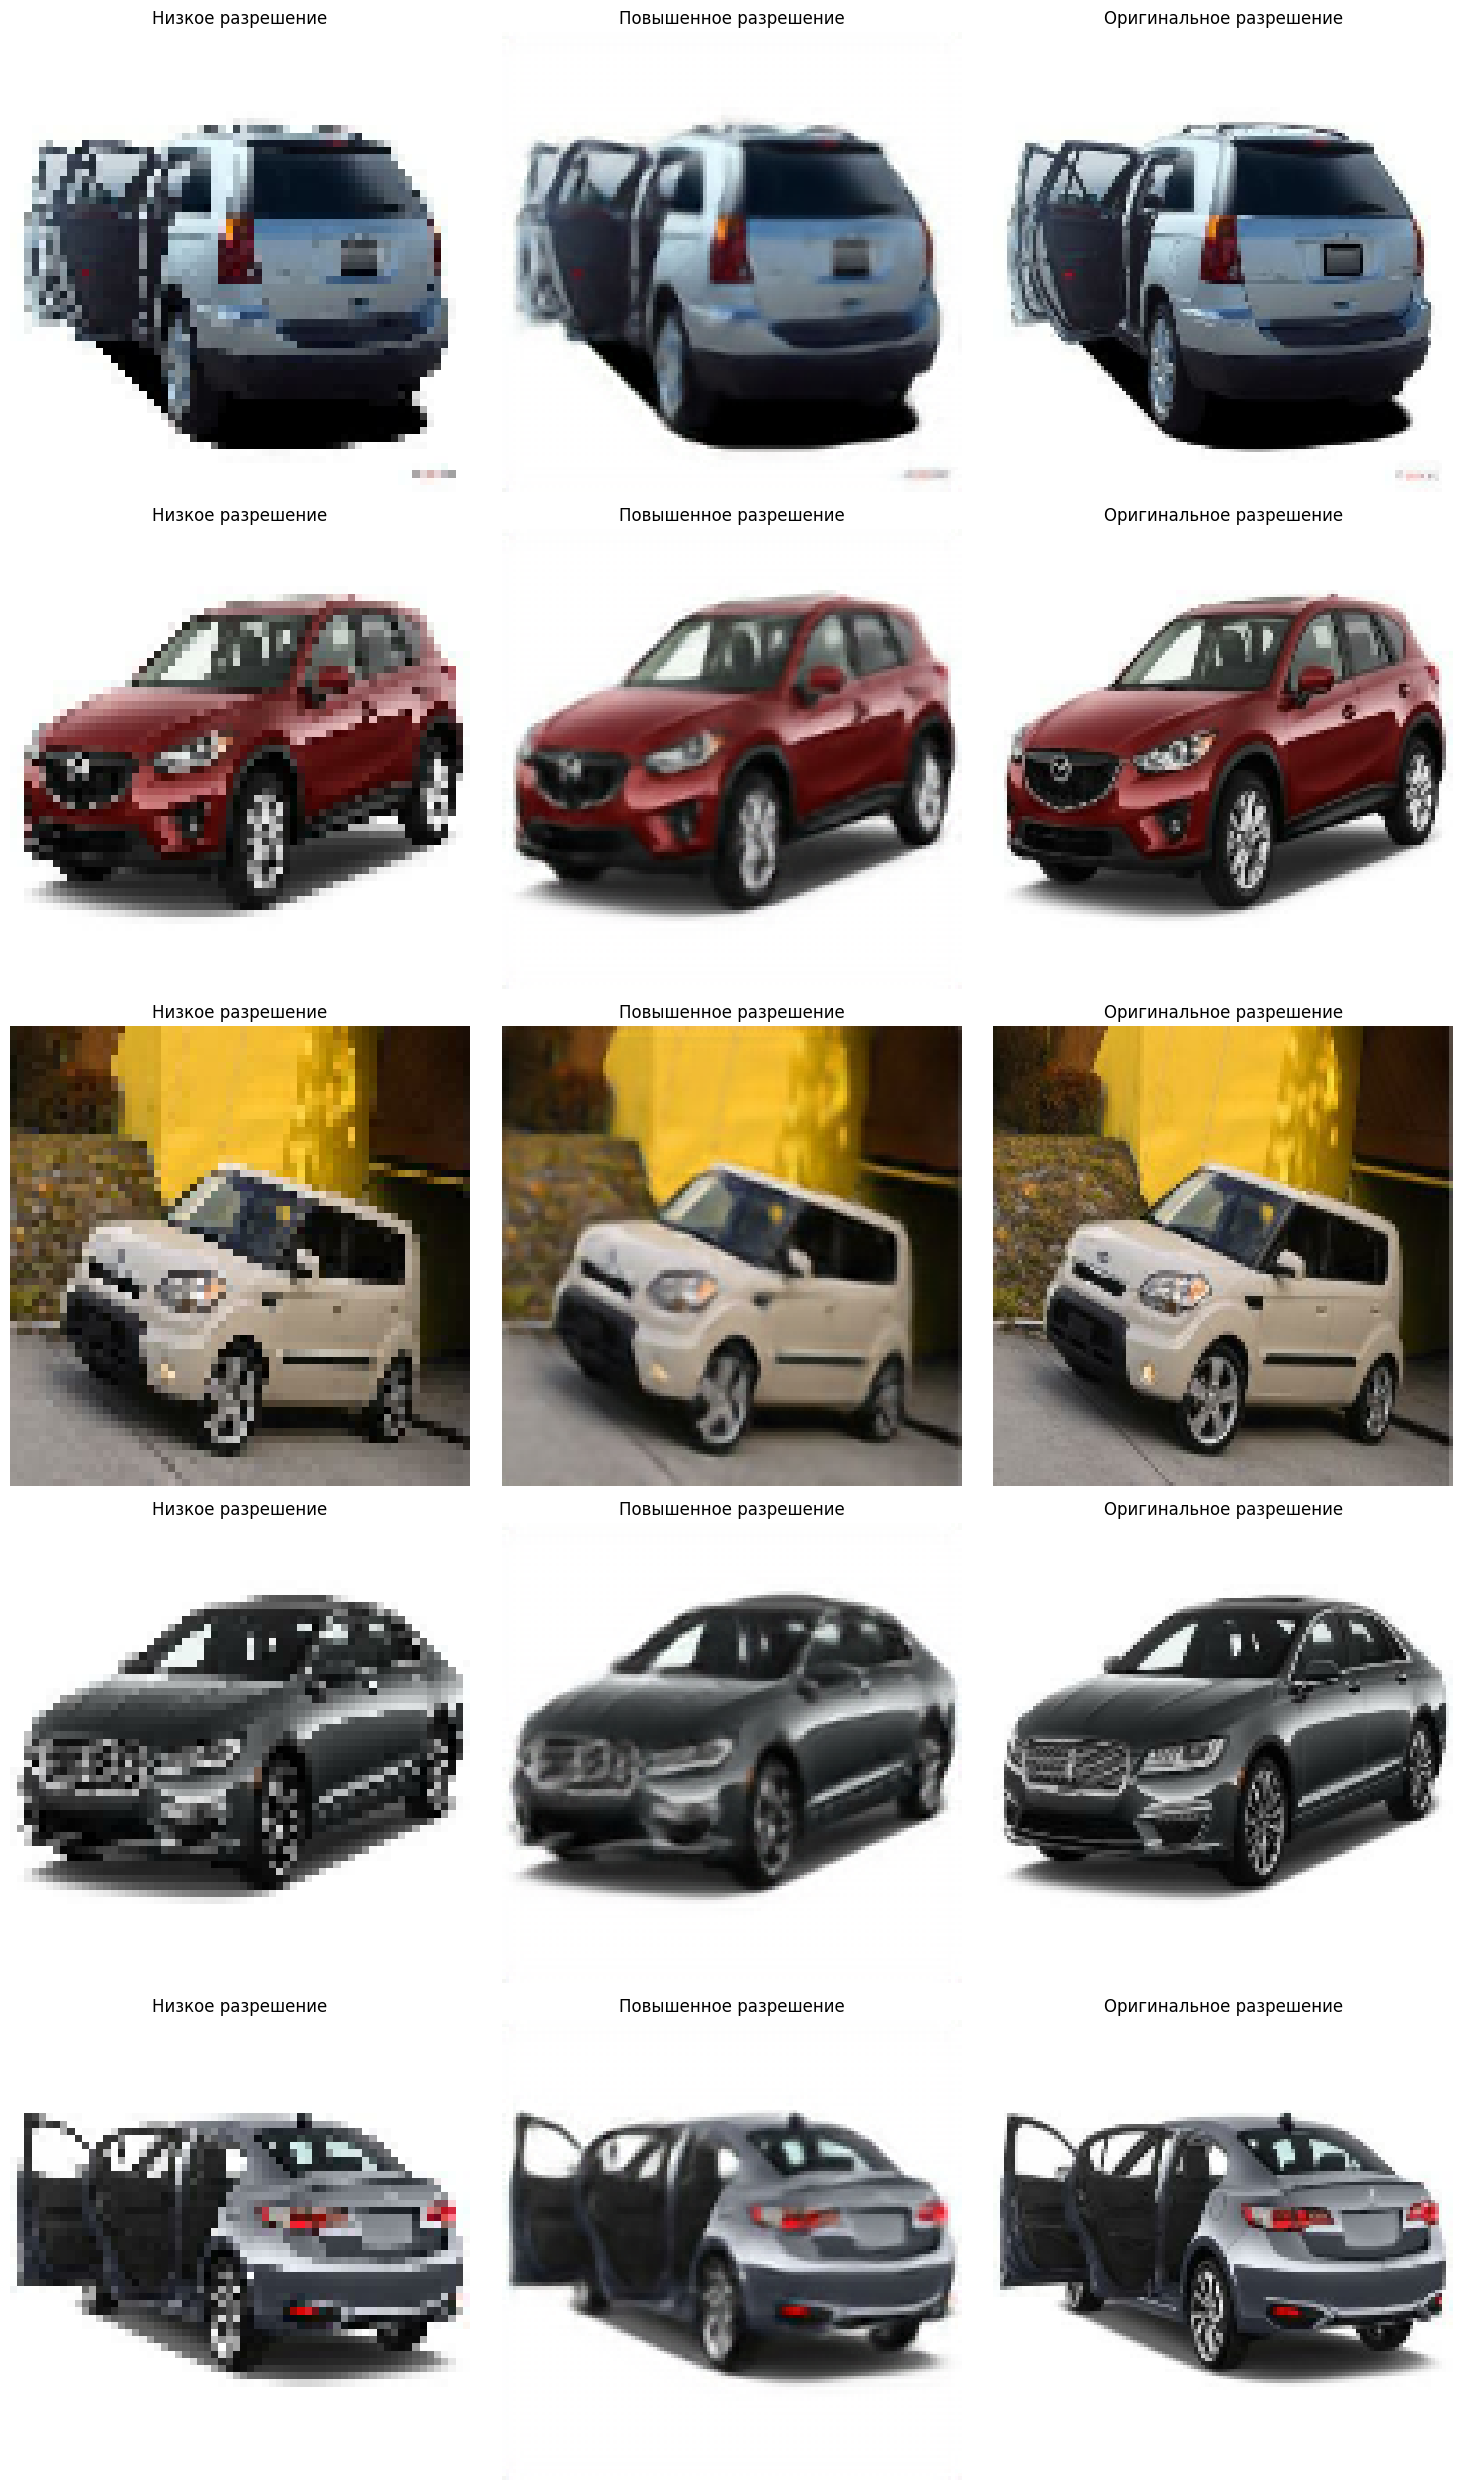

In [22]:
low_res_images, high_res_images = next(iter(validation_dataset))

super_resolved_images = model.predict(low_res_images)

def super_resolve_and_display(low_res, high_res, super_resolved, num_images=5):
    plt.figure(figsize=(15, num_images * 5))
    for i in range(min(num_images, len(low_res))):
        plt.subplot(num_images, 3, 3*i + 1)
        plt.imshow(((low_res[i].numpy() + 1) / 2).clip(0, 1))
        plt.title('Низкое разрешение')
        plt.axis('off')

        plt.subplot(num_images, 3, 3*i + 2)
        plt.imshow(((super_resolved[i] + 1) / 2).clip(0, 1))
        plt.title('Повышенное разрешение')
        plt.axis('off')

        plt.subplot(num_images, 3, 3*i + 3)
        plt.imshow(((high_res[i].numpy() + 1) / 2).clip(0, 1))
        plt.title('Оригинальное разрешение')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

super_resolve_and_display(low_res_images, high_res_images, super_resolved_images)

## Итог

Реализована модель повышения разрешения изображений на основе ESPCN, адаптированная для работы с датасетом автомобилей.